In [12]:
import sys
if 'src' not in sys.path:
    sys.path.append('src')
    
from scipy.stats import kendalltau,spearmanr,pearsonr,gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

np.random.seed(42)

cell_line = "imr90"
run_name = "paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-neg"

results = np.load(f'../results/{cell_line}/{run_name}/results.npz')

pred_dim = 200
res = 5000

targets = np.reshape(results['targets'], [-1, pred_dim])
predictions = np.reshape(results['predictions'], [-1, pred_dim])
predictions = np.clip(predictions, 0, None)
chr_data = np.reshape(results['chr_data'], [-1, pred_dim])
pos1 = np.reshape(results['pos1_data'], [-1, pred_dim])//res
pos2 = np.reshape(results['pos2_data'], [-1, pred_dim])//res
print(targets.shape, predictions.shape, chr_data.shape, pos1.shape, pos2.shape)

(29900, 200) (29900, 200)


In [16]:
# Create result dataframe
result_df = pd.DataFrame({
    'chrom': chr_data.flatten(),
    'bin1': pos1.flatten(),
    'bin2': pos2.flatten(),
    'target': targets.flatten(),
    'preds': predictions.flatten()
})
result_df['dist'] = abs(result_df['bin2']-result_df['bin1'])
result_df = result_df[result_df.dist < 203]

In [17]:
# Remove unmappable regions
unmap = pd.read_csv("../data/blacklist/basenji_unmappable.bed", sep="\t", names=["chr", "start", "end"])
test_chr = [*result_df.chrom.unique()]
unmap = unmap[unmap.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    unmap_chr = unmap[unmap.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(unmap_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

final_df = []
for chr, drop_list in drop_info.items():
    df_filter = result_df[result_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    final_df.append(df_filter)
final_df = pd.concat(final_df, ignore_index=True)
final_df.head()

114616it [00:02, 42083.90it/s]
46535it [00:01, 42829.81it/s]
78231it [00:01, 41635.51it/s]


(1261578, 6)
(183297, 6)
(468356, 6)
(9568, 6)
(901463, 6)
(114022, 6)


,chrom,bin1,bin2,target,preds,dist
chrom,1.000000,-0.324402,-0.324373,0.014409,0.026416,0.006517
bin1,-0.324402,1.000000,0.999991,-0.007641,-0.011955,-0.002067
bin2,-0.324373,0.999991,1.000000,-0.011219,-0.015716,0.002286
target,0.014409,-0.007641,-0.011219,1.000000,0.936476,-0.821816
preds,0.026416,-0.011955,-0.015716,0.936476,1.000000,-0.863841
dist,0.006517,-0.002067,0.002286,-0.821816,-0.863841,1.000000


In [18]:
# Remove general blacklisted regions
blacklist = pd.read_csv("../data/blacklist/basenji_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['start']
        end = row['end']
        skip_regions = []
        i = start
        while i<=end:
            skip_regions.append(i//5000)
            i+=5000
        drop_list.extend(skip_regions)
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

0it [00:00, ?it/s]

183it [00:00, 32607.91it/s]
869it [00:00, 41791.07it/s]
73it [00:00, 35996.26it/s]

(183169, 6)
(8737, 6)
(113863, 6)


,chrom,bin1,bin2,target,preds,dist
chrom,1.000000,-0.322888,-0.322868,0.013317,0.026410,0.004433
bin1,-0.322888,1.000000,0.999991,-0.007325,-0.011827,-0.001610
bin2,-0.322868,0.999991,1.000000,-0.010901,-0.015585,0.002740
target,0.013317,-0.007325,-0.010901,1.000000,0.936508,-0.821847
preds,0.026410,-0.011827,-0.015585,0.936508,1.000000,-0.863938
dist,0.004433,-0.001610,0.002740,-0.821847,-0.863938,1.000000


In [19]:
# Remove cell-type-specific blacklisted regions
blacklist = pd.read_csv(f"../data/blacklist/{cell_line.lower()}_blacklist.bed", sep="\t", names=["chr", "start", "end"])
blacklist = blacklist[blacklist.chr.isin(test_chr)]
drop_info = {}
for chr in test_chr:
    blacklist_chr = blacklist[blacklist.chr == chr]
    chr = int(chr.split("chr")[-1])
    blacklist_chr['bin1'] = blacklist_chr.start//5000
    
    drop_list = []
    for _,row in tqdm(blacklist_chr.iterrows()):
        start = row['bin1']
        skip_regions = [start, start+1, start-1]
        drop_list.extend(skip_regions)
    
    drop_info[chr] = drop_list

df_list = []
for chr, drop_list in drop_info.items():
    df_filter = final_df[final_df.chrom==chr]
    df_filter = df_filter[~df_filter.bin1.isin(drop_list)]
    df_filter = df_filter[~df_filter.bin2.isin(drop_list)]
    df_list.append(df_filter)
final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

<ipython-input-19-5e99eacd7214>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacklist_chr['bin1'] = blacklist_chr.start//5000
2662it [00:00, 47888.23it/s]
585it [00:00, 45310.75it/s]
2015it [00:00, 47459.67it/s]

(157178, 6)
(5983, 6)
(93112, 6)


,chrom,bin1,bin2,target,preds,dist
chrom,1.000000,-0.299901,-0.299868,0.018895,0.018570,0.009130
bin1,-0.299901,1.000000,0.999991,0.000247,-0.004016,-0.006617
bin2,-0.299868,0.999991,1.000000,-0.003347,-0.007752,-0.002290
target,0.018895,0.000247,-0.003347,1.000000,0.945986,-0.830612
preds,0.018570,-0.004016,-0.007752,0.945986,1.000000,-0.863474
dist,0.009130,-0.006617,-0.002290,-0.830612,-0.863474,1.000000


In [20]:
# Chromosome-wise correlation
for chr in test_chr:
    chr = int(chr.split("chr")[-1])
    df_chr = final_df[final_df.chrom == chr] 
    
    p1 = pearsonr(df_chr['preds'].values, df_chr['target'])[0]
    s1 = spearmanr(df_chr['preds'].values, df_chr['target'])[0]
    t1 = kendalltau(df_chr['preds'].values, df_chr['target'])[0]
    print("UniversalEPI")
    print(f"{cell_line}({chr}): \t R: {np.round(p1,3)}; Rho: {np.round(s1,3)}; Tau: {np.round(t1,3)}")

UniversalEPI
imr90(2): 	 R: 0.948; Rho: 0.938; Tau: 0.79
UniversalEPI
imr90(19): 	 R: 0.922; Rho: 0.895; Tau: 0.744
UniversalEPI
imr90(6): 	 R: 0.946; Rho: 0.935; Tau: 0.785


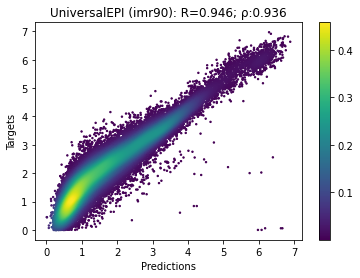

In [21]:
# Final scatter plot
t_b = np.array(final_df['target'].values.tolist())
t_hat_b = np.array(final_df['preds'].values.tolist())
r = np.round(pearsonr(t_b, t_hat_b)[0],3)
rho = np.round(spearmanr(t_b, t_hat_b)[0],3)
idx_subset = np.random.choice(np.arange(len(t_b)), size=50000, replace=False)
t_b_subset = t_b[idx_subset]
t_hat_b_subset = t_hat_b[idx_subset]
xy = np.vstack([t_hat_b_subset, t_b_subset])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
t_hat_b_subset, t_b_subset, z = t_hat_b_subset[idx], t_b_subset[idx], z[idx]
plt.scatter(t_hat_b_subset, t_b_subset, c=z, s=2)
plt.title(f"UniversalEPI ({cell_line}): R={r}; ρ:{rho}")
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.colorbar()
plt.show()    

Text(0.5, 0.98, 'Distance Stratified Correlation')

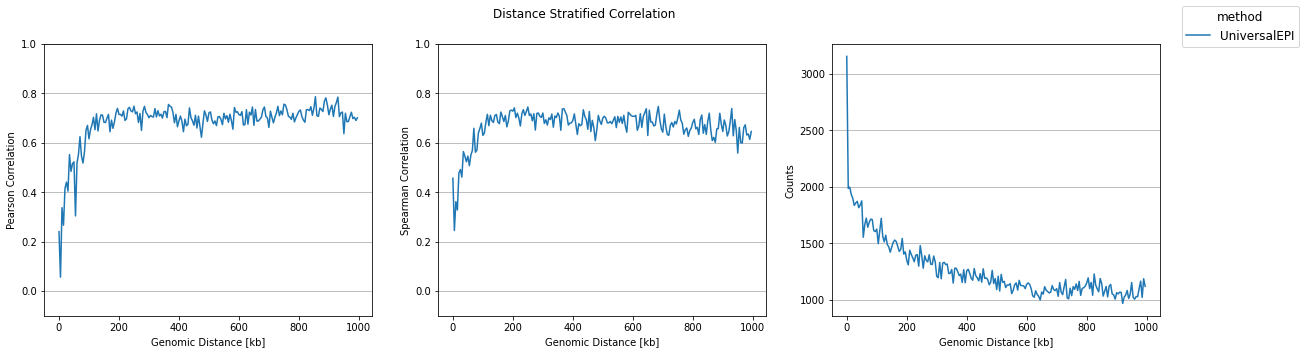

In [22]:
r_d_200 = []
rho_d_200 = []
n_samples = []

for index in range(np.uint(1000000/res)):
    t_b_i = np.array(final_df[final_df.dist == index]['target'].values.tolist())
    t_hat_b_i = np.array(final_df[final_df.dist == index]['preds'].values.tolist())

    n_samples.append(len(np.array(t_b_i).flatten()))
    
    r_d_200.append(pearsonr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())[0])
    rho, _ = spearmanr(np.array(t_b_i).flatten(), np.array(t_hat_b_i).flatten())
    rho_d_200.append(rho)

x_label = np.arange(0,len(r_d_200)) * res / 1000

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax[0].plot(x_label, np.array(r_d_200), label="UniversalEPI")
ax[0].grid(axis='y')
ax[0].set_ylim(-0.1,1)
ax[0].set_xlabel("Genomic Distance [kb]")
ax[0].set_ylabel("Pearson Correlation")

ax[1].plot(x_label, np.array(rho_d_200), label="UniversalEPI")
ax[1].grid(axis='y')
ax[1].set_ylim(-0.1,1)
ax[1].set_xlabel("Genomic Distance [kb]")
ax[1].set_ylabel("Spearman Correlation")

ax[2].plot(x_label, np.array(n_samples), label="UniversalEPI")
ax[2].grid(axis='y')
ax[2].set_xlabel("Genomic Distance [kb]")
ax[2].set_ylabel("Counts")

lines, labels = ax[1].get_legend_handles_labels()
f.legend(lines, labels, loc="upper right", title="method", fontsize='large', title_fontsize='large')
f.suptitle("Distance Stratified Correlation")